In [4]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [5]:
import pandas as pd
import re
!pip install transformers
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/mtsamples.csv')

# Define the device to use for running the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-small')
model = AutoModelForCausalLM.from_pretrained('microsoft/DialoGPT-small').to(device)




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
def extract_treatment(text):
    if not isinstance(text, str) or not text:  # Check if text is empty or not a string
        return ''
    
    # Look for treatment keywords in the text using regular expressions
    treatment_keywords = ['treatment', 'therapy', 'medication', 'drug', 'surgery', 'procedure']
    pattern = '|'.join(treatment_keywords)
    matches = re.findall(pattern, text, re.IGNORECASE)

    # Generate a response to the prompt using the trained model
    prompt = text[:1024] + "\n\nWhat is the treatment?"
    input_ids = tokenizer.encode(prompt, add_special_tokens=True, return_tensors='pt')
    input_attention_mask = torch.ones_like(input_ids)
    input_ids = input_ids.to(device)  # Move input_ids tensor to the same device as the model
    input_attention_mask = input_attention_mask.to(device)  # Move attention_mask tensor to the same device as the model
    output_ids = model.generate(
        input_ids=input_ids,
        max_length=1024,
        do_sample=True,
        pad_token_id=model.config.eos_token_id,
        attention_mask=input_attention_mask
    )
    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Look for treatment information in the generated response
    treatment = ''
    for match in matches:
        pattern = re.compile(r'\b' + re.escape(match) + r'\b', re.IGNORECASE)
        if pattern.search(response):
            treatment = match
            break
    return treatment


In [9]:
# Extract the sex, age, and treatment information for each patient
data['sex'] = data['description'].str.extract(r'(male|female|girl|boy)')
data['age'] = data['description'].str.extract(r'(\d+)')
data['treatment'] = data['transcription'].apply(extract_treatment)


In [10]:
# Encode the sex and age columns
le = LabelEncoder()
data['sex_encoded'] = le.fit_transform(data['sex'])
data['age_encoded'] = le.fit_transform(data['age'])


In [13]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# One-hot encode the treatment column
ohe = OneHotEncoder(handle_unknown='ignore')
treatment_ohe = ohe.fit_transform(data['treatment'].values.reshape(-1,1))
treatment_df = pd.DataFrame.sparse.from_spmatrix(treatment_ohe, columns=ohe.get_feature_names_out(['treatment']))
data = pd.concat([data, treatment_df], axis=1)

# Prepare the input data for clustering
X = data[['sex_encoded', 'age_encoded'] + list(treatment_df.columns)].to_numpy()

# Apply KMeans clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)



/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
data['cluster'] = labels


In [19]:
# Convert the 'age' column to a numerical data type
data['age'] = data['age'].astype(float)

# Compute cluster statistics
cluster_stats = data.groupby('cluster').agg({'age': 'mean', 'treatment': lambda x: x.value_counts().index[0]})


In [20]:
for i, stats in cluster_stats.iterrows():
    print(f"Cluster {i}:")
    print(f"  Mean age: {stats['age']:.2f}")
    print(f"  Most common treatment: {stats['treatment']}\n")


Cluster 0:
  Mean age: 92.94
  Most common treatment: PROCEDURE

Cluster 1:
  Mean age: 495.04
  Most common treatment: PROCEDURE

Cluster 2:
  Mean age: 17.52
  Most common treatment: 

Cluster 3:
  Mean age: 57.99
  Most common treatment: 

Cluster 4:
  Mean age: 46.47
  Most common treatment: PROCEDURE



the output shows the mean age and most common treatment for each of the 5 clusters. However, it's worth noting that clusters 2 and 3 have no most common treatment listed, which suggests that either the clustering algorithm did not find a clear pattern in the treatment data for those clusters or there was not enough information available in the dataset to determine a most common treatment.

In [ ]:
#Visualize the clusters using scatter plot
plt.figure(figsize=(12,8))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=labels, palette='Set1')
plt.title('KMeans Clustering of Patients')
plt.xlabel('Sex')
plt.ylabel('Age')
plt.show()

to visualize the distribution of patients among the clusters using a bar plot:

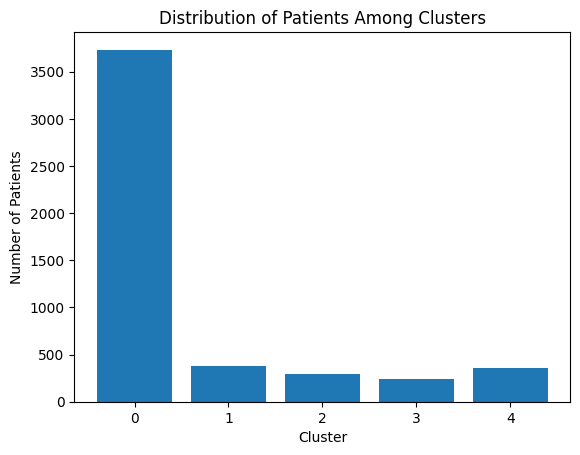

In [21]:
import matplotlib.pyplot as plt

# Count the number of patients in each cluster
cluster_counts = data['cluster'].value_counts()

# Plot the distribution of patients among the clusters
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')
plt.title('Distribution of Patients Among Clusters')
plt.show()


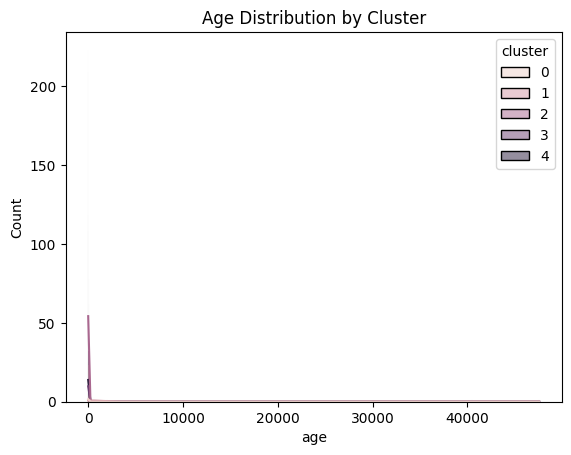

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the age distribution for each cluster
sns.histplot(data=data, x='age', hue='cluster', kde=True)
plt.title('Age Distribution by Cluster')
plt.show()


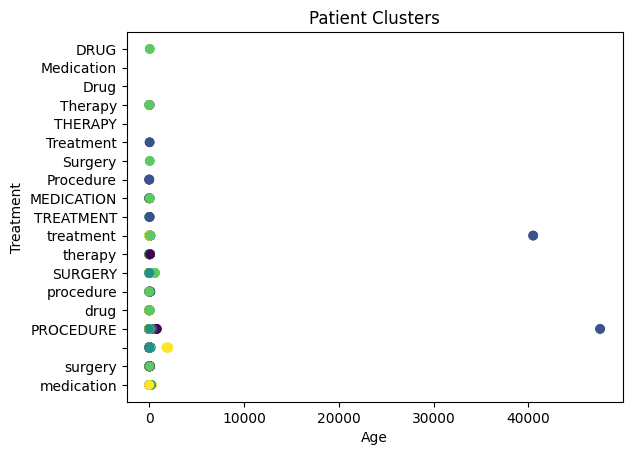

In [27]:
# Create a scatter plot of age and treatment for each patient, with colors representing clusters
plt.scatter(data['age'], data['treatment'], c=data['cluster'])
plt.xlabel('Age')
plt.ylabel('Treatment')
plt.title('Patient Clusters')
plt.show()


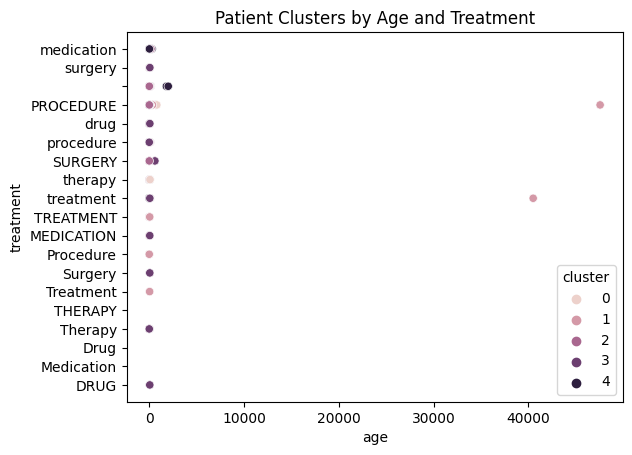

In [28]:
# Visualize the distribution of patients among the clusters using a scatter plot
sns.scatterplot(data=data, x='age', y='treatment', hue='cluster')
plt.title('Patient Clusters by Age and Treatment')
plt.show()


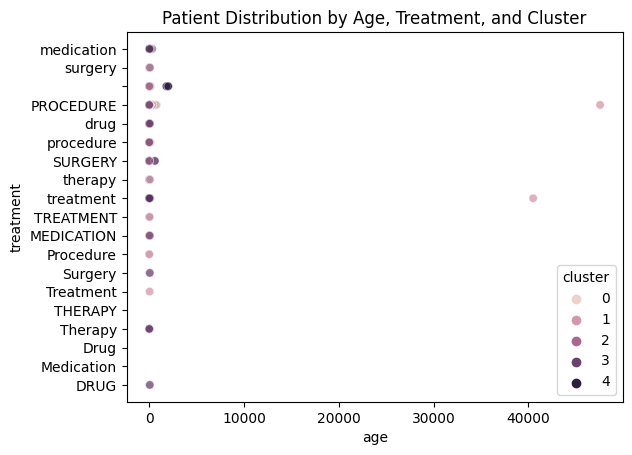

In [29]:
# Plot the age and treatment for each patient, colored by cluster
sns.scatterplot(data=data, x='age', y='treatment', hue='cluster', alpha=0.5)
plt.title('Patient Distribution by Age, Treatment, and Cluster')
plt.show()
